In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import warnings
from st_loading_utils import load_DLPFC

In [4]:
import STAGATE_pyG as STAGATE
section_list = ['151673', '151674', '151675', '151676']

In [6]:
adata_list = {}
for section_id in section_list:
    input_dir = os.path.join('/home/yunfei/spatial_benchmarking/benchmarking_data/DLPFC12')
    temp_adata = load_DLPFC(root_dir=input_dir, section_id=section_id)
    temp_adata.var_names_make_unique()

    temp_adata.obs_names = [x+'_'+section_id for x in temp_adata.obs_names]

    adata_list[section_id] = temp_adata.copy()

/home/yunfei/anaconda3/envs/test/lib/python3.7/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/yunfei/anaconda3/envs/test/lib/python3.7/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/yunfei/anaconda3/envs/test/lib/python3.7/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/yunfei/anaconda3/envs/test/lib/python3.7/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


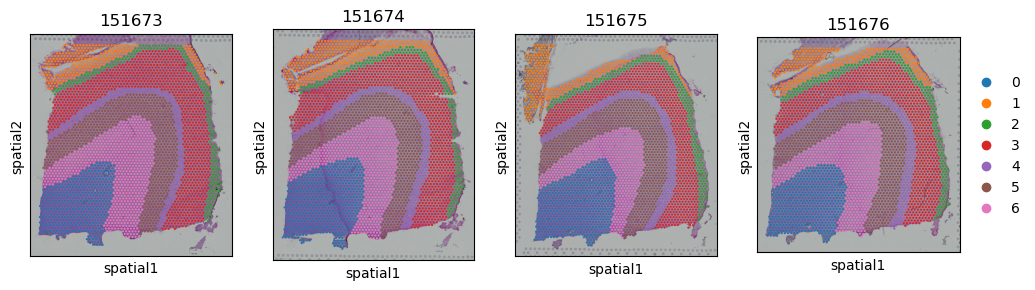

In [8]:
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
it=0
for section_id in section_list:
    if it == 3:
        sc.pl.spatial(adata_list[section_id], img_key="hires", ax=axs[it],
                      color=["original_clusters"], title=section_id, show=False)
    else:
        sc.pl.spatial(adata_list[section_id], img_key="hires", ax=axs[it], legend_loc=None,
                      color=["original_clusters"], title=section_id, show=False)
    it+=1

------Calculating spatial graph...
The graph contains 21038 edges, 3611 cells.
5.8261 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 21134 edges, 3635 cells.
5.8140 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 20688 edges, 3566 cells.
5.8015 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 19966 edges, 3431 cells.
5.8193 neighbors per cell on average.


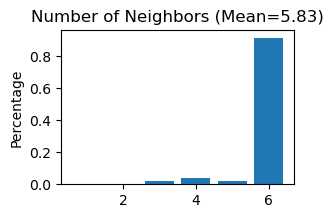

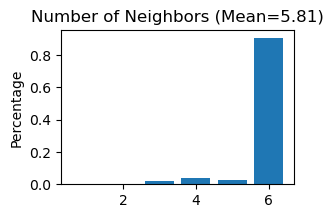

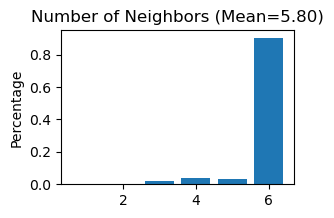

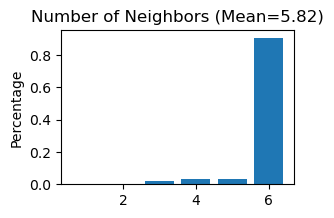

In [9]:
for section_id in section_list:
    STAGATE.Cal_Spatial_Net(adata_list[section_id], rad_cutoff=150)
    STAGATE.Stats_Spatial_Net(adata_list[section_id])

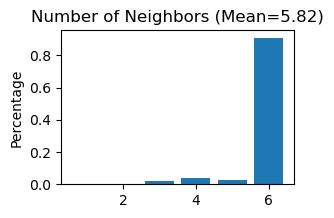

In [10]:
adata = sc.concat([adata_list[x] for x in section_list], keys=None)
adata.uns['Spatial_Net'] = pd.concat([adata_list[x].uns['Spatial_Net'] for x in section_list])
STAGATE.Stats_Spatial_Net(adata)


In [12]:
#Normalization
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

adata = STAGATE.train_STAGATE(adata)

sc.pp.neighbors(adata, use_rep='STAGATE')
sc.tl.umap(adata)
adata = STAGATE.mclust_R(adata, used_obsm='STAGATE', num_cluster=7)


/home/yunfei/anaconda3/envs/test/lib/python3.7/site-packages/scanpy/preprocessing/_highly_variable_genes.py:64: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  UserWarning,


Size of Input:  (14243, 3000)


100%|██████████| 1000/1000 [00:35<00:00, 28.20it/s]
R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 5.4.10
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


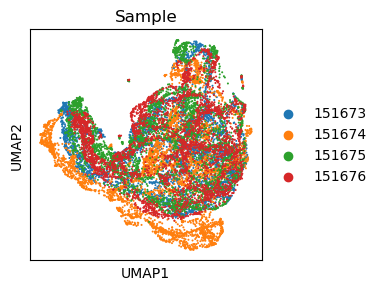

In [13]:
adata.obs['Sample'] = [x.split('_')[-1] for x in adata.obs_names]
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.umap(adata, color='Sample')

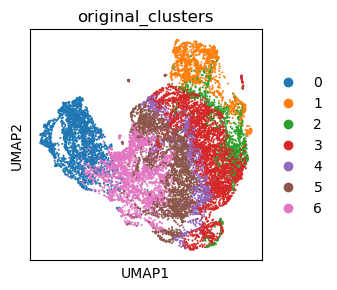

In [15]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.umap(adata, color='original_clusters')

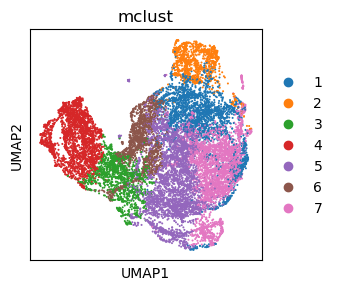

In [16]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.umap(adata, color='mclust')

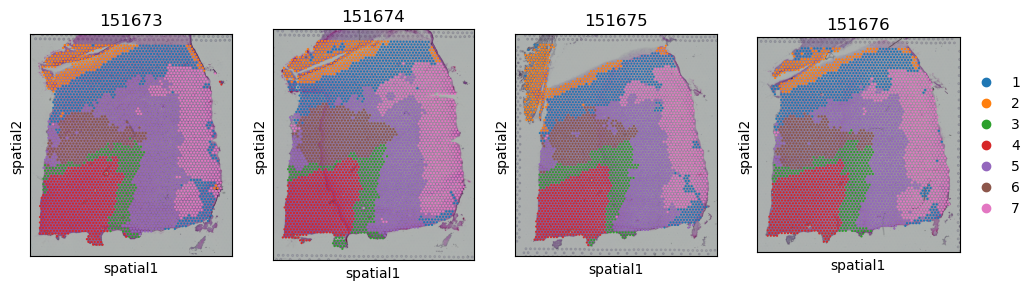

In [19]:
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
it=0
for section_id in section_list:
    adata_list[section_id].obs['STAGATE'] = adata.obs.loc[adata_list[section_id].obs_names, 'mclust']
    if it == 3:
        sc.pl.spatial(adata_list[section_id], img_key="hires", ax=axs[it],
                      color=["STAGATE"], title=section_id, show=False)
    else:
        sc.pl.spatial(adata_list[section_id], img_key="hires", ax=axs[it], legend_loc=None,
                      color=["STAGATE"], title=section_id, show=False)
    it+=1

In [18]:
from sklearn.metrics.cluster import adjusted_rand_score
for section_id in section_list:
    temp_adata = adata[adata.obs['Sample']==section_id]
    temp_obs = temp_adata.obs.dropna()
    temp_ARI = adjusted_rand_score(temp_obs['mclust'], temp_obs['original_clusters'])
    print('ARI of section ID %s: %.3f' %(section_id, temp_ARI))

ARI of section ID 151673: 0.414
ARI of section ID 151674: 0.414
ARI of section ID 151675: 0.458
ARI of section ID 151676: 0.447
